In [ ]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt 
import chardet
import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point, LineString
import folium 
from folium import Marker, GeoJson
from folium.plugins import MarkerCluster, HeatMap

# 🗺️ Task 1: Static Maps — Hospital Count by District

In [2]:
# Carga el archivo IPRESS, filtra registros en funcionamiento y elimina filas con valores nulos o cero en NORTE/ESTE.
def cargar_ipress(ruta_csv):
        
    df = pd.read_csv(ruta_csv, encoding='latin-1')
    
    # Filtrar por condición
    df = df[df['Condición'] == 'EN FUNCIONAMIENTO']
    
    # Filtrar NaN y ceros en coordenadas
    df = df.dropna(subset=['NORTE', 'ESTE'])
    df = df[(df['NORTE'] != 0) & (df['ESTE'] != 0)]
    
    # Renombrar columnas
    df = df.rename(columns={'ESTE': 'Latitud', 'NORTE': 'Longitud'})
    
    # Asegurar tipo numérico
    df['Latitud'] = pd.to_numeric(df['Latitud'], errors='coerce')
    df['Longitud'] = pd.to_numeric(df['Longitud'], errors='coerce')
    
    # Eliminar nuevamente posibles NaN generados en la conversión
    df = df.dropna(subset=['Latitud', 'Longitud']).reset_index(drop=True)
    
    # Ajustar UBIGEO antes o después de filtrar
    df["UBIGEO"] = df["UBIGEO"].astype(str).str.zfill(6)
    
    # Filtramos las columnas deseadas
    df.columns = df.columns.str.upper()
    df = df[[
            "INSTITUCIÓN",
            "NOMBRE DEL ESTABLECIMIENTO",
            "CLASIFICACIÓN",
            "DEPARTAMENTO",
            "PROVINCIA",
            "DISTRITO",
            "ESTADO",
            "LATITUD",
            "LONGITUD",
            "UBIGEO"
            ]]
    return df


In [5]:
def plot_hospitales(dataset_cv, filtro="all", color="#9DDE8B", titulo=None):
   
    # --- 1. Aplicar filtro ---
    if filtro == "with":
        dataset_filtrado = dataset_cv[dataset_cv['INSTITUCIÓN'].notna()]
        titulo_auto = "Map: Districts with hospitals"
    elif filtro == "without":
        dataset_filtrado = dataset_cv[dataset_cv['INSTITUCIÓN'].isna()]
        titulo_auto = "Map: Districts without hospitals"
    elif filtro == "top10":
        hospitales_por_distrito = (
            dataset_cv.groupby(["UBIGEO","geometry"])["INSTITUCIÓN"]
            .count().reset_index(name="n_hospitales")
        )
        dataset_filtrado = gpd.GeoDataFrame(
            hospitales_por_distrito.nlargest(10, "n_hospitales"),
            geometry=hospitales_por_distrito["geometry"],
            crs=dataset_cv.crs
        )
        titulo_auto = "Map 3: Top 10 districts with the highest number of hospitals"
    else:
        dataset_filtrado = dataset_cv.copy()
        titulo_auto = "Map: All districts"
    
    # --- 2. Crear figura ---
    fig, ax = plt.subplots(figsize=(20, 20))
    
    # Fondo
    dataset_cv.plot(
        ax=ax,
        facecolor="none",
        edgecolor="gray",
        linewidth=0.5,
        linestyle='dotted'
    )
    
    # Filtrado encima
    if filtro == "top10":
        dataset_filtrado.plot(
            ax=ax,
            column="n_hospitales",   # escala de color según número de hospitales
            cmap="Reds",          # paleta de colores distinta
            edgecolor="white",
            linewidth=1,
            legend=True
        )
    else:
        dataset_filtrado.plot(
            ax=ax,
            color=color,
            edgecolor="white",
            linewidth=1,
            linestyle='dotted',
            legend=True,
        )
    
    # --- 3. Título ---
    plt.title(titulo if titulo else titulo_auto, fontsize=18, fontweight="bold")
    plt.show()


In [6]:
#Carga de data IPRESS
ruta = r'../../data/IPRESS.csv'
df = cargar_ipress(ruta)

In [7]:
#Carga de data de distritos
maps = gpd.read_file(r'../../data/DISTRITOS.shp')

In [8]:
# Seleccionamos las columnas relevantes
maps = maps[['IDDIST', 'geometry']]
maps = maps.rename({'IDDIST':'UBIGEO'}, axis =1 )

In [9]:
# Aseguramos el formato WGS-84 (EPSG:4326)
maps = maps.to_crs(epsg=4326)

In [10]:
#Creamos el dataframe que vamos a utilizar para el ploteo
dataset_cv = pd.merge(maps, df, how="left", on="UBIGEO")

### Map 1: Total public hospitals per district.

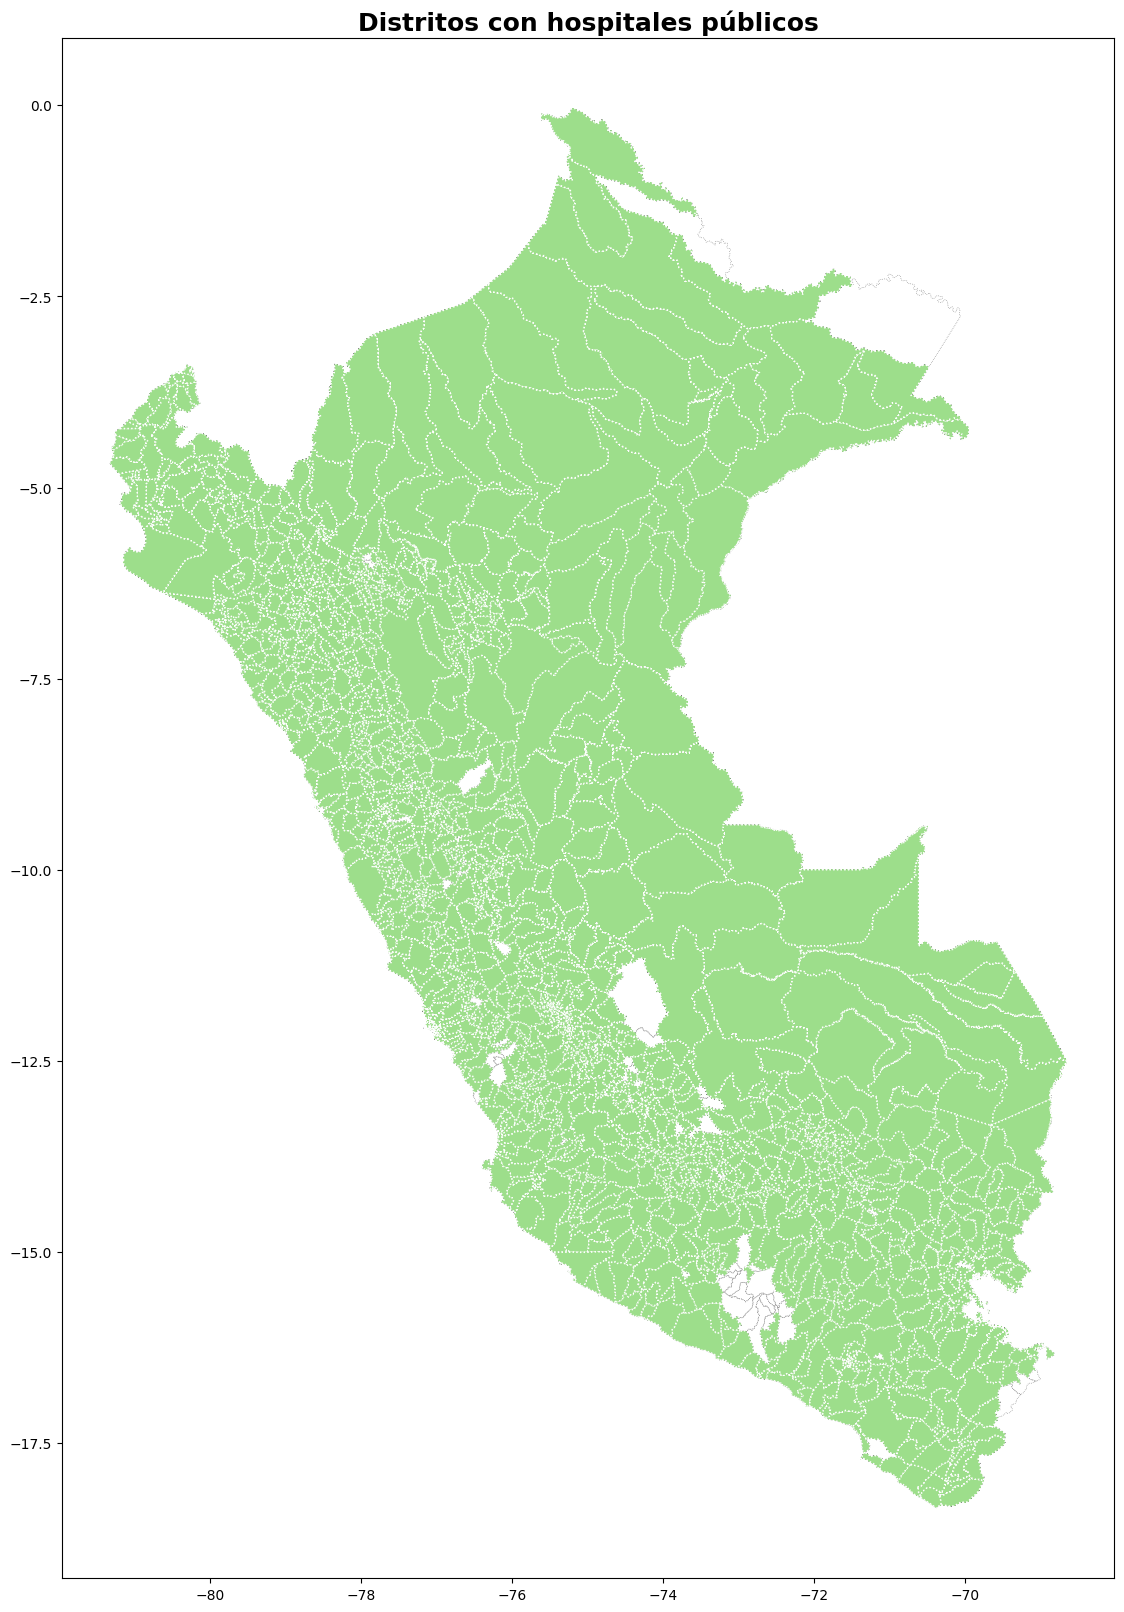

In [11]:
# Distritos con hospitales
plot_hospitales(dataset_cv, filtro="with", titulo="Distritos con hospitales públicos")

### Map 2: Highlight districts with zero hospitals.

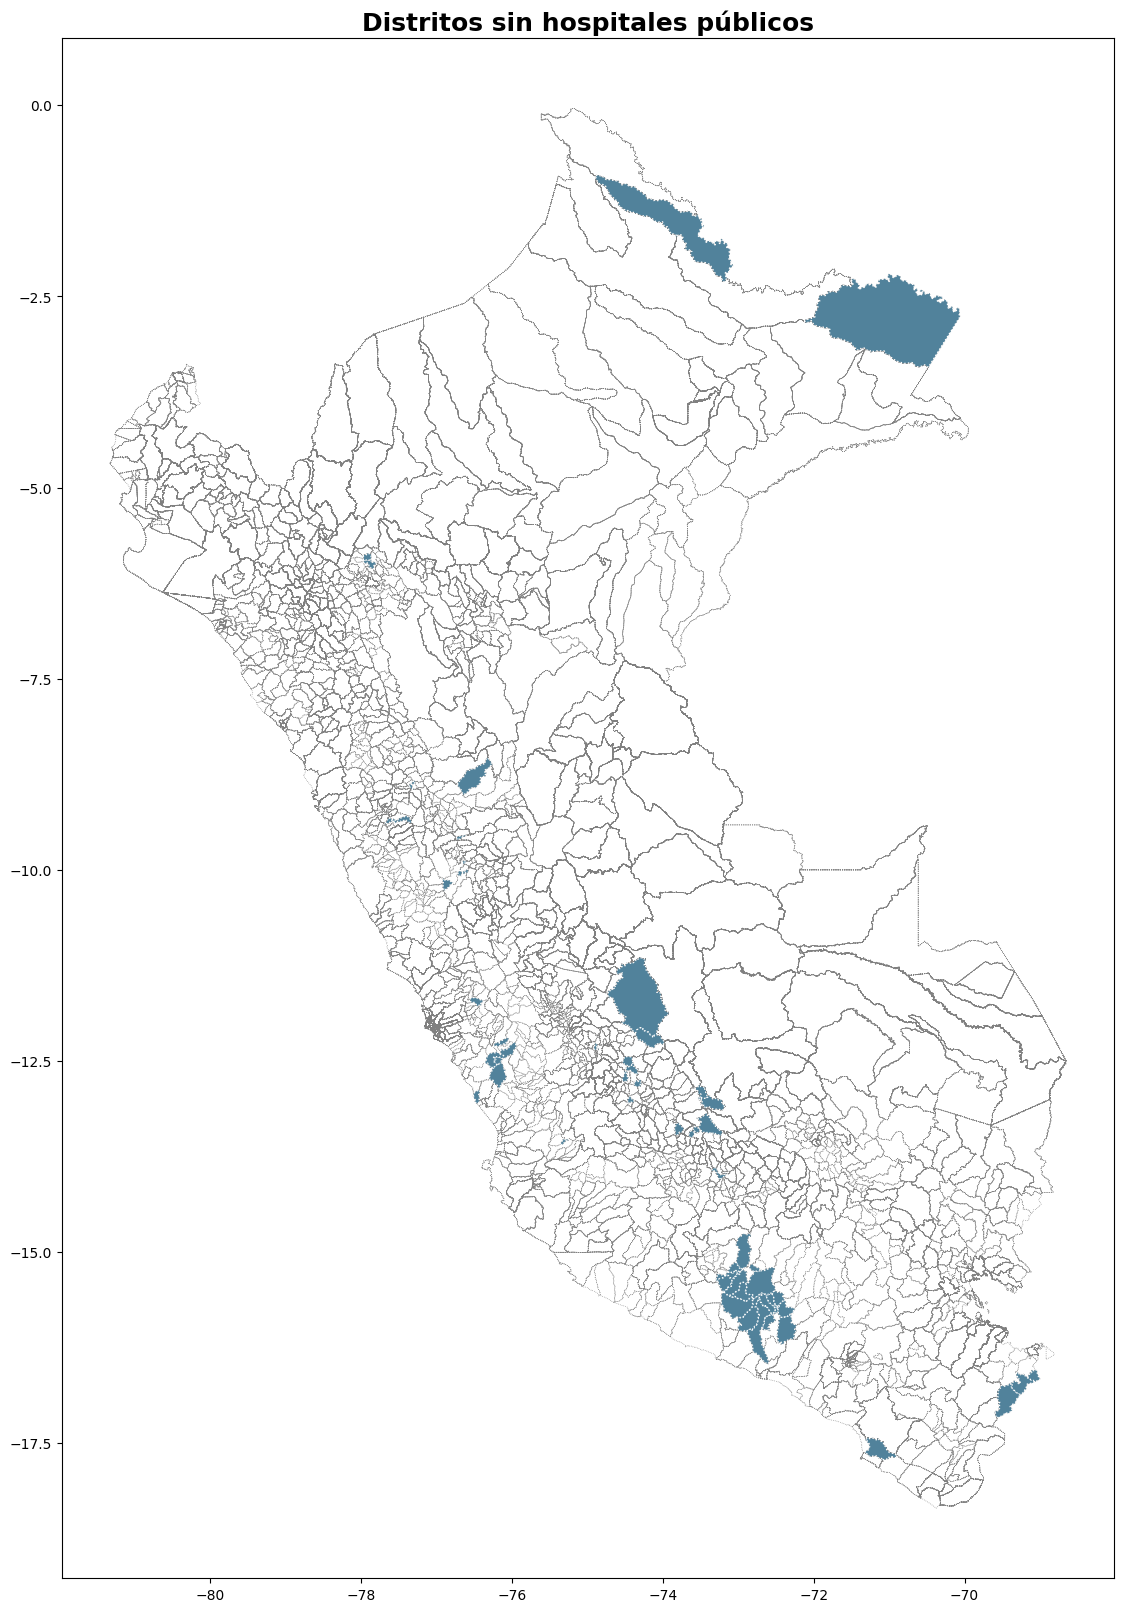

In [12]:
# Distritos sin hospitales
plot_hospitales(dataset_cv, filtro="without",color='#51829B', titulo="Distritos sin hospitales públicos")

### Map 3: Top 10 districts with the highest number of hospitals (distinct color scale).

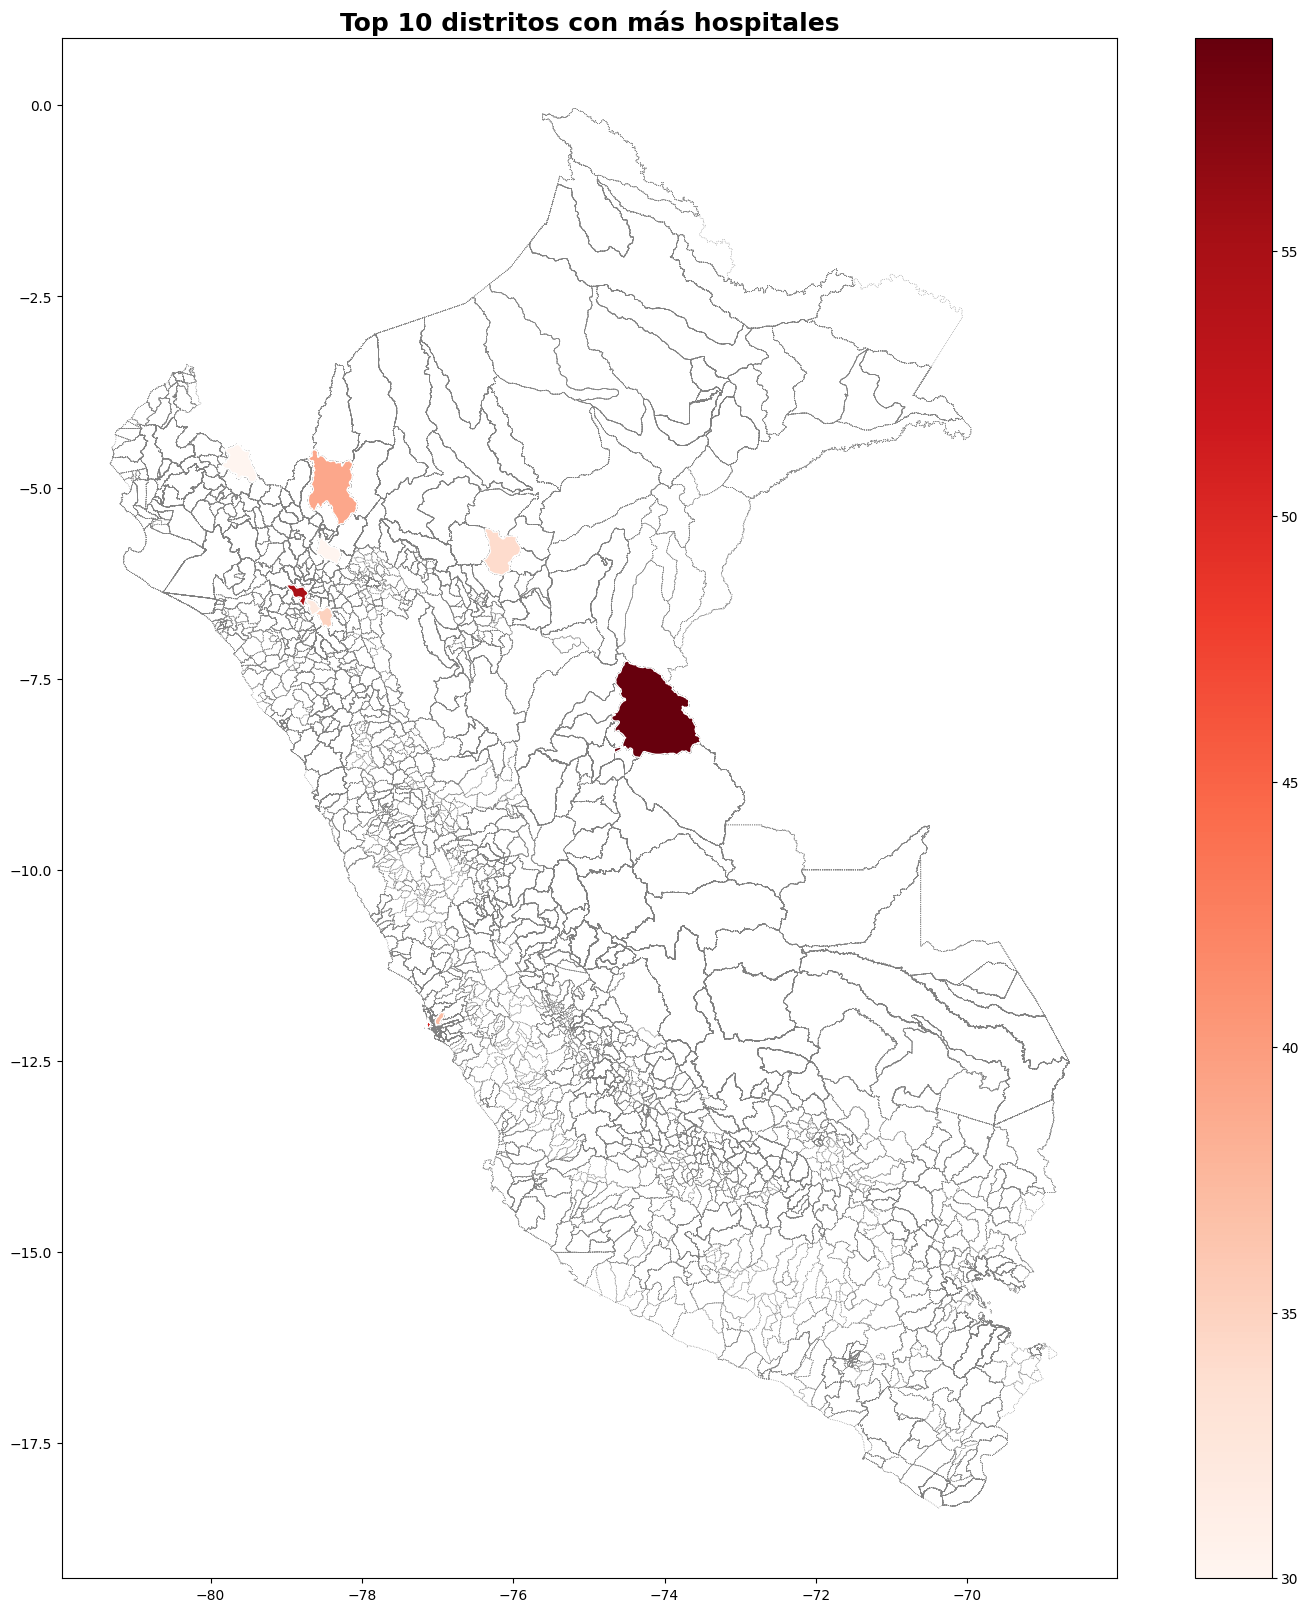

In [13]:
# Top 10 distritos con más hospitales
plot_hospitales(dataset_cv, filtro="top10", titulo="Top 10 distritos con más hospitales")